<a href="https://colab.research.google.com/github/Nov05/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/others/2019_06_13_Chi_squared_test_from_Lecture_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# modified by nov05 on 2019-06-13
# originally modified by Taylor Bickell

# DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments
# others/

**Chi-squared test 
(example from Lecture Notes)**

In [0]:
import scipy.stats
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import altair as alt

from IPython.display import display, Image
from google.colab import files

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# import warnings
# warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [0]:
!curl https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv

In [0]:
# Create a dataframe, and in this case, 
# replace the missing values indicated with ' ?' with NaN values.
url='https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv'
df = pd.read_csv(url, na_values=' ?')

In [5]:
# check NAs
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
country            583
salary               0
dtype: int64

In [8]:
print(df.shape)
df.head(2)

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [9]:
# Summary statistics for the numeric features of data frame
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [10]:
# Summary statistics for the non-numeric features of data frame
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [0]:
# The two variables/attributes we want to 
# take a closer look at are sex and hours-per-week.

# Our question: Is there a relationship 
# between sex and hours per week worked?

In [0]:
# Notice that hours-per-week is semi-continuous.

# So, we're going to bin hours per week, 
# and create a new column after doing this. 

# Now we have a representation of hours-per-week that is more in line 
# with being a categorical variable, which is critical for us 
# to perform a Chi-squared test!

cut_points = [0, 9, 19, 29, 39, 49, 1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']

# Create a new column.
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], 
                                         cut_points, 
                                         labels=label_names)

In [17]:
# Verify that the new column is in df.
df[['hours-per-week', 'hours_per_week_categories']].sample(5)

,hours-per-week,hours_per_week_categories
28053,40,40-49
30861,40,40-49
7211,60,50+
9873,41,40-49
7465,40,40-49


In [18]:
# How many males and females? 
# Looking at this gives an initial idea of proportion
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [19]:
# Here we see that most people work 40-49 hours per week
df['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [20]:
# Notice that our bottom margin is out of sync and doesn't correspond correctly 
# with our value counts totals above.

# We'll need to sort our hours_per_week_categories column.

ct = pd.crosstab(df['sex'], 
                 df['hours_per_week_categories'], 
                 margins=True)
ct

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,6462,1246,18336,3667,458,2392,32561


In [0]:
df = df.sort_values(by='hours_per_week_categories', 
                    ascending=True)

In [24]:
# Now, we can create an accurate cross table!

## Note: A table with totals and in terms of percentage would be coded as:
# ct = pd.crosstab(data_df['sex'], 
#                  data_df['hours_per_week_categories'], 
#                  margins=True, 
#                  normalize=True)

ct = pd.crosstab(df['sex'], 
                 df['hours_per_week_categories'], 
                 margins=True,
#                  normalize=True
                            )
ct

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [0]:
# We only really want to grab the center section of our crosstab table. 
# This is called our contingency table.

In [25]:
# Instead of pulling the values for females and males out as just DataFrame 
# rows, .values translates the rows into numpy arrays which will make it 
# easier to do our math. 

femalecounts = crosstab_table.iloc[0][0:6].values
femalecounts

array([ 235,  671, 1287, 1914, 5636, 1028])

In [26]:
malecounts = crosstab_table.iloc[1][0:6].values
malecounts

array([  223,   575,  1105,  1753, 12700,  5434])

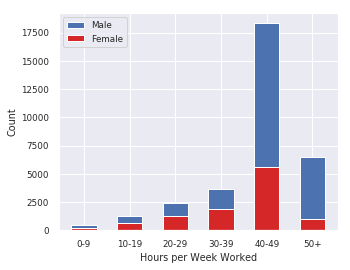

In [30]:
# Create a visualization that gives us an initial idea ("eyeball test") 
# of what's going on with our data.

# Stacked bar chart

fig = plt.figure(figsize=(5, 4))
sns.set(font_scale=0.8)
categories = ["0-9","10-19","20-29","30-39","40-49","50+"]
p1 = plt.bar(categories, femalecounts, 0.55, color='#d62728')
p2 = plt.bar(categories, malecounts, 0.55, bottom=femalecounts)
plt.legend((p2[0], p1[0]), ('Male', 'Female'))
plt.xlabel('Hours per Week Worked')
plt.ylabel('Count')
plt.show()

# We see that proportions are not being maintained throughout each 
# category of hours per week worked.

**Expected Value calculation**

In [34]:
# Get the 'All'(total) column values and 'All' row values from our crosstab 
# and save as a numpy array. Here, we are essentially grabbing the margins 
# of our crosstab.

row_totals = ct.iloc[0:2, 6].values
col_totals = ct.iloc[2, 0:6].values

print(row_totals)
print(col_totals)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [45]:
ttl = crosstab_table.loc['All', 'All']
print(all_all_total)

32561


<img src="https://image.slidesharecdn.com/chisquaretestfinal-140131063217-phpapp02/95/chi-square-test-final-39-638.jpg" width="300">

In [47]:
# We'll loop through our row and column totals to get our arrays of 
# expected values. We want this to be an array of arrays(2-D numpy array) 
# to help make the calculations a little easier.

expected = []

for i in range(len(row_totals)):
  row = []
  for col_total in col_totals:
    val = col_total * row_totals[i] / ttl
    row.append(val)
  expected.append(row)
  
print(np.array(expected))

[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [58]:
# I love list comprehension
exp1 = np.array([[col_ttl * row_ttl / ttl for col_ttl in col_totals] 
                 for row_ttl in row_totals])
exp1

array([[  151.50388502,   412.16995793,   791.26046497,  1213.02346365,
         6065.44811277,  2137.59411566],
       [  306.49611498,   833.83004207,  1600.73953503,  2453.97653635,
        12270.55188723,  4324.40588434]])

In [48]:
# Observed
# Again, in order to get a numpy array, use .values on our crosstab.

observed = pd.crosstab(df['sex'], 
                       df['hours_per_week_categories']).values
observed

array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

**Hypotheses for Chi-squared test**

*   Null hypothesis: These variables have an independent relationship.
*   Alternative hypothesis: These variables have a dependent relationship.

#Chi-squared statistic with Numpy

\begin{align}
\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}
\end{align}

For the $observed$ values we will just use a version of our contingency table without the margins as a numpy array. In this way, if our observed values array and our expected values array are the same shape, then we can subtract them and divide them directly which makes the calculations a lot cleaner. No for loops!

In [49]:
# Chi-sqaured statistic
chi_squared = ((observed - expected)**2/(expected)).sum()
print(f"Chi-squared: {chi_squared}")

Chi-squared: 2287.190943926107


In [52]:
# Degrees of freedom
dof = (len(row_totals)-1) * (len(column_totals)-1)
print(f"Degrees of freedom: {dof}")   

Degrees of freedom: 5


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html  

In [51]:
# Now, using SciPy, the one-liner way to run a Chi-squared test!

hi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-squared: 2287.190943926107
P-value: 0.0
Degrees of freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


Given the results of this test, I reject the null hypothesis. This means that there is a dependent relationship that exists between these two variables. In looking more closely at and thinking about the time period this data was collected from, we could see how sex and hours per week worked could in fact have a dependent relationship.